In [1]:
import requests
from os.path import exists
from PIL import Image
#Color processing
from colorthief import ColorThief
import numpy as np
import pandas as pd
import time

In [2]:
img_folder = 'offers_imgs/'

In [3]:
def download_img(img_url):
    img_path = url_to_path(img_url)
    response = requests.get(img_url)
    if not response.ok:
        return None
    img_data = response.content
    with open(img_path, 'wb') as handler:
        handler.write(img_data)
        return img_path
        
def url_to_path(url):
    end = url.index('?')
    start = end - 36
    return img_folder + url[start:end].replace('/', '-')

def get_img(url):
    path = url_to_path(url)
    if exists(path):
        return path
    else:
        return download_img(url)

def get_concat_h(img_url_list):
    im = []
    for url in img_url_list:
        imgurl = get_img(url)
        im += [Image.open(get_img(url))] if imgurl is not None else []
    tot_width = sum([el.width for el in im])
    dst = Image.new('RGB', (tot_width, im[0].height))
    shift = 0
    for el in im:
        dst.paste(el, (shift, 0))
        shift += el.width
    return dst

In [4]:
img_list_u = ['https://img01.ztat.net/article/a797f668349e4dd0b5c876df89e6054f/663b9daacfa144f69e53043a4ff48f6e.jpg?imwidth=762',
       'https://img01.ztat.net/article/f8ebb88249ea4b279d6ca3515bb70517/cbf1297043bf4f5d9c06af99d6878101.jpg?imwidth=762',
       'https://img01.ztat.net/article/eaf874a6b7d548fcaea270c8c6f2d0cc/7632acaaaffa473a81214ad3c8ed76c8.jpg?imwidth=762',
       'https://img01.ztat.net/article/80edaca0e93845fca385211db2e02e53/0a4dc54405274ffcba2a16082c3af4ab.jpg?imwidth=762',
       'https://img01.ztat.net/article/86b9e1aaeb61498ab28f62b0622b02d6/0cad5a69289e41e0a3bdc7ec526584af.jpg?imwidth=762',
       'https://img01.ztat.net/article/d20c898d555d482dbba67495b4bbedf2/5cb566bac7fc47d2a94ab0e37793d3a8.jpg?imwidth=762',
       'https://img01.ztat.net/article/f69cf90dd5434b1da13993e1f36d0765/98ae60e47b3443d8a8153fd72dc23e2c.jpg?imwidth=762']

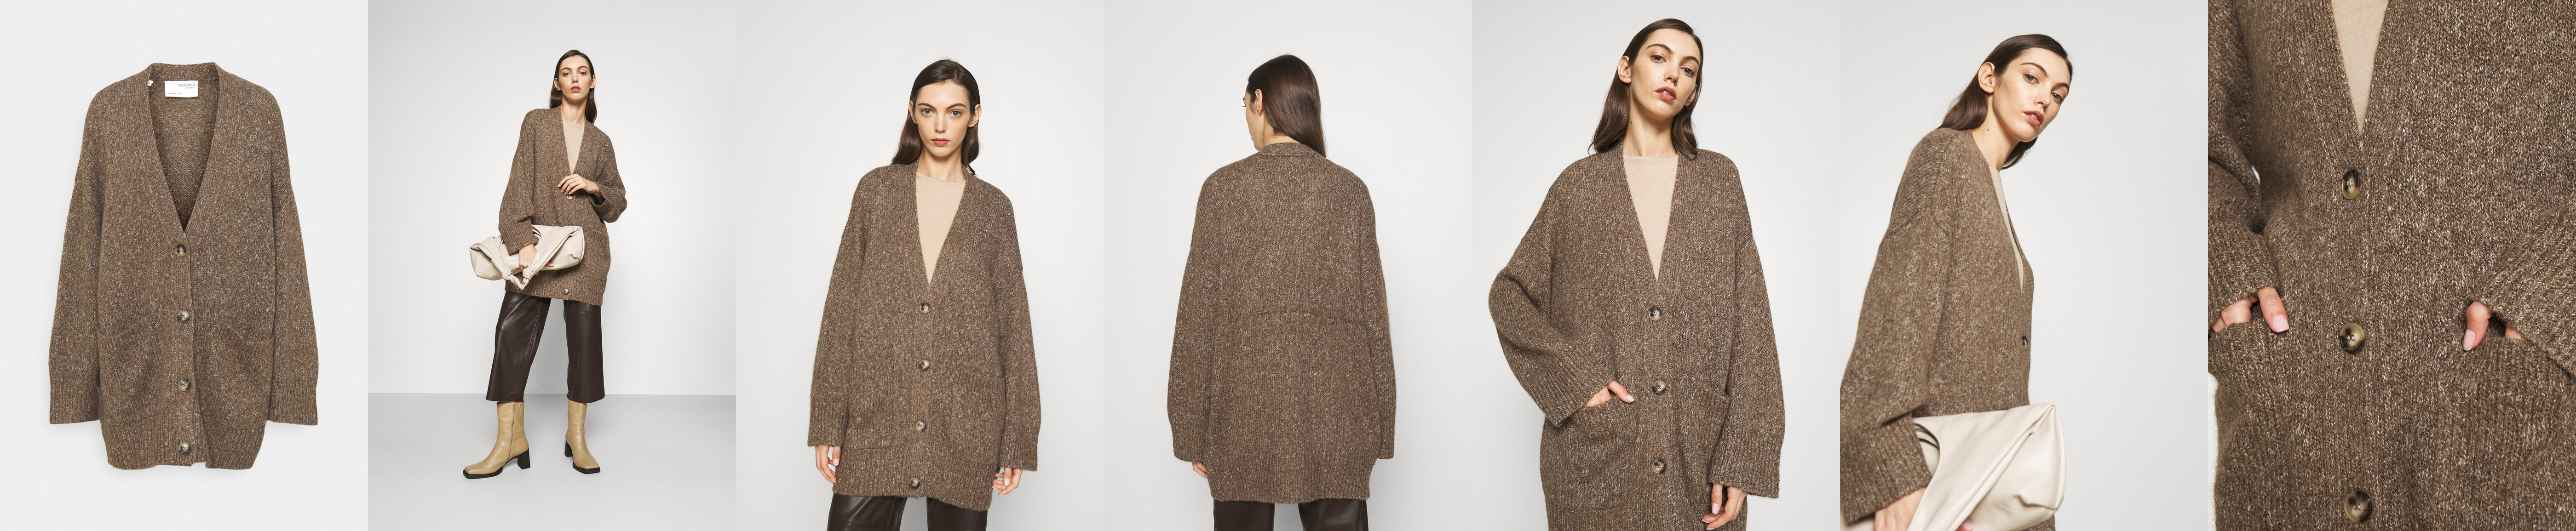

In [5]:
get_concat_h(img_list_u)

In [6]:
class MyColorThief(ColorThief):
    def __init__(self, img):
        self.image = img

In [7]:
def get_palette_imgs(img_list, color_count=4):
    return MyColorThief(get_concat_h(img_list)).get_palette(color_count)

def color_difference(col_1, col_2):
    r_1, r_2 = col_1[0], col_2[0]
    g_1, g_2 = col_1[1], col_2[1]
    b_1, b_2 = col_1[2], col_2[2]
    return ((r_1-r_2)**2 + (g_1-g_2)**2 + (b_1-b_2)**2)**(1/2) / ((3*255**2)**(1/2))

def color_palette_most_similar(col, pal):
    score = 1
    most_similar = pal[0]
    for c in pal:
        diff = color_difference(col, c)
        if diff < score:
            score = diff
            most_similar = c
    return most_similar

def palette_distance(pal_1, pal_2):
    return sum([color_difference(col_1, color_palette_most_similar(col_1, pal_2)) 
                for col_1 in pal_1])/len(pal_1)

def palette_similarity(pal_1, pal_2):
    return 1 - palette_distance(pal_1, pal_2)

pal = get_palette_imgs(img_list_u)
palette_similarity(pal, [(72, 63, 49), (112, 96, 78), (225, 224, 217), (145, 121, 111)])

0.9817661225916626

### Calculate palette for all offers_training records

In [ ]:
def write_palettes():
    offers_training_df = pd.read_parquet('../data/offers_training.parquet')
    df_palette = pd.DataFrame(columns=['offer_id', 'palette'])
    for index, el in offers_training_df.loc[:][['offer_id', 'image_urls']].iterrows():
        try:
            row = {'offer_id': el['offer_id'], 'palette': get_palette_imgs(el['image_urls'])}
            df_palette = df_palette.append(row, ignore_index=True)
            time.sleep(1)
        except:
            pass
    df_palette.to_parquet('../data/palette.parquet')
    
#write_palettes()